This notebook establishes an initial end-to-end prototype for estimating food volume from two handheld images of a plate. The current pipeline successfully detects the plate, estimates relative camera pose, produces a dense disparity map using RAFT-Stereo, and converts this into a per-pixel height map over the plate. On empty-plate tests, the geometry is structurally correct (the plate is largely flat with small noise), demonstrating that the core stereo and plane-fitting stack is functioning.

However, the prototype is not yet production-ready. Absolute metric scaling is still unstable (e.g., empty plate volume is inflated), the RAFT-based depth step is too slow for CPU deployment, and specular highlights introduce noticeable noise in the height map. The next iteration will focus on introducing a deterministic scale anchor (using the known plate rim height above the table), improving robustness to glare and low texture, and replacing the heavy stereo backend with a CPU-friendly alternative while preserving the current height-map-based volume architecture.

In [1]:
# ======================
# Core
# ======================
import os
import math
import json
import random
from pathlib import Path

# ======================
# Numerical / CV
# ======================
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ======================
# Torch (for later models)
# ======================
import torch
import torchvision

# ======================
# Colab utilities
# ======================
from google.colab import files
from IPython.display import display

# ======================
# Plot settings
# ======================
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.cmap"] = "viridis"

print("✅ Imports loaded")
print(f"🔥 Torch CUDA available: {torch.cuda.is_available()}")

✅ Imports loaded
🔥 Torch CUDA available: False


In [2]:
# ====================================
# Global config
# ====================================

CONFIG = {
    # --- required input ---
    "plate_diameter_cm": 26.0,  # 🔴 USER WILL CHANGE

    # --- image handling ---
    "max_image_dim": 1024,      # resize long side for speed
    "rgb": True,

    # --- visualization ---
    "show_debug": True,
    "random_seed": 42,

    # --- future (not used yet, but keep) ---
    "ransac_plane_thresh_cm": 0.5,
    "food_height_thresh_cm": 0.5,
}

# Reproducibility
random.seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
torch.manual_seed(CONFIG["random_seed"])

print("✅ Config initialized")

✅ Config initialized


In [4]:
# ====================================
# Upload two images
# ====================================

print("Upload TWO plate images (img1 and img2)...")
uploaded = files.upload()

# Basic validation
if len(uploaded) < 2:
    raise ValueError("❌ Please upload at least TWO images.")

# Sort for deterministic order
image_paths = sorted(uploaded.keys())

IMG1_PATH = image_paths[0]
IMG2_PATH = image_paths[1]

print(f"✅ Using:\n  img1 = {IMG1_PATH}\n  img2 = {IMG2_PATH}")

Upload TWO plate images (img1 and img2)...


Saving empty_plate_left.jpg to empty_plate_left.jpg
Saving empty_plate_top.jpg to empty_plate_top (1).jpg
✅ Using:
  img1 = empty_plate_left.jpg
  img2 = empty_plate_top (1).jpg


img1 shape: (768, 1024, 3)
img2 shape: (768, 1024, 3)


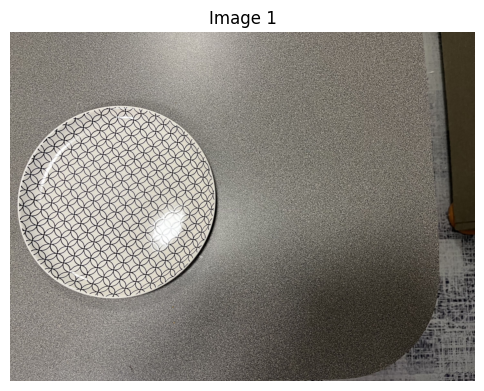

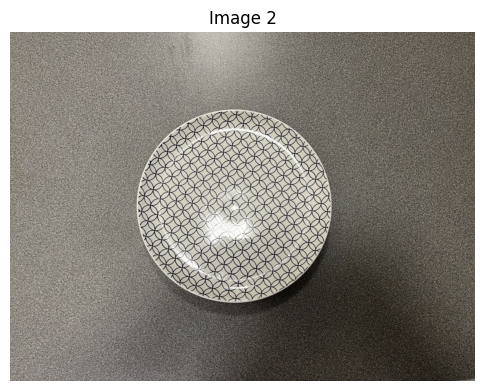

✅ Images loaded and displayed


In [5]:
# ====================================
# Image helpers
# ====================================

def read_image(path, rgb=True):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"❌ Failed to read image: {path}")
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def resize_max_dim(img, max_dim):
    h, w = img.shape[:2]
    scale = max_dim / max(h, w)

    if scale >= 1:
        return img, 1.0

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized, scale


def show_image(img, title=""):
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


# ====================================
# Load + preprocess
# ====================================

img1 = read_image(IMG1_PATH, CONFIG["rgb"])
img2 = read_image(IMG2_PATH, CONFIG["rgb"])

img1, scale1 = resize_max_dim(img1, CONFIG["max_image_dim"])
img2, scale2 = resize_max_dim(img2, CONFIG["max_image_dim"])

print(f"img1 shape: {img1.shape}")
print(f"img2 shape: {img2.shape}")

show_image(img1, "Image 1")
show_image(img2, "Image 2")

print("✅ Images loaded and displayed")

In [9]:
import numpy as np
import cv2
import math


def detect_plate_mask(image_rgb: np.ndarray) -> np.ndarray:
    """
    Detect the main plate as a filled ellipse mask.

    Input:
        image_rgb: HxWx3 RGB image

    Output:
        mask: HxW uint8 mask (255 = plate, 0 = background)

    Assumptions:
        - plate is fully visible
        - plate is roughly circular
        - rim has edge contrast
    """

    h, w = image_rgb.shape[:2]

    # ---------- 1. edge map ----------
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(gray, 60, 160)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # ---------- 2. contours ----------
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        return np.zeros((h, w), dtype=np.uint8)

    img_area = h * w
    best_score = -1
    best_ellipse = None

    # ---------- 3. evaluate candidates ----------
    for cnt in contours:
        if len(cnt) < 80:
            continue

        area = cv2.contourArea(cnt)
        if area < 0.01 * img_area:
            continue

        try:
            ellipse = cv2.fitEllipse(cnt)
        except:
            continue

        (cx, cy), (a, b), angle = ellipse
        major = max(a, b)
        minor = min(a, b)

        # reject extremely skinny ellipses
        if minor / major < 0.4:
            continue

        # ---------- rim support scoring ----------
        # sample points along ellipse perimeter
        num_samples = 360
        theta = np.linspace(0, 2*np.pi, num_samples)

        cos_a = math.cos(math.radians(angle))
        sin_a = math.sin(math.radians(angle))

        rx = major / 2
        ry = minor / 2

        hits = 0
        valid = 0

        for t in theta:
            x = rx * np.cos(t)
            y = ry * np.sin(t)

            # rotate
            xr = x * cos_a - y * sin_a
            yr = x * sin_a + y * cos_a

            px = int(cx + xr)
            py = int(cy + yr)

            if 0 <= px < w and 0 <= py < h:
                valid += 1

                # small neighborhood check for robustness
                x0 = max(px - 2, 0)
                x1 = min(px + 3, w)
                y0 = max(py - 2, 0)
                y1 = min(py + 3, h)

                if np.any(edges[y0:y1, x0:x1] > 0):
                    hits += 1

        if valid == 0:
            continue

        support_ratio = hits / valid

        # slight size prior (plate should be reasonably large)
        size_score = min(1.0, major / max(h, w))

        score = support_ratio * (0.7 + 0.3 * size_score)

        if score > best_score:
            best_score = score
            best_ellipse = ellipse

    # ---------- 4. build mask ----------
    mask = np.zeros((h, w), dtype=np.uint8)

    if best_ellipse is not None:
        cv2.ellipse(mask, best_ellipse, 255, thickness=-1)

    return mask

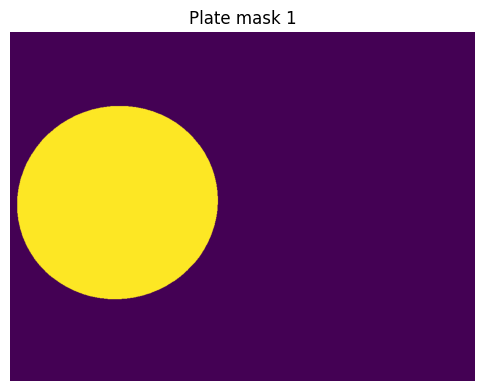

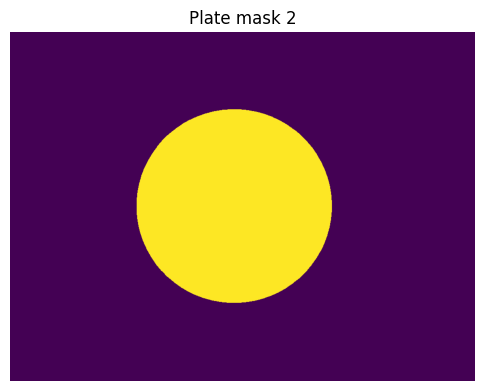

In [10]:
mask1 = detect_plate_mask(img1)
mask2 = detect_plate_mask(img2)

show_image(mask1, "Plate mask 1")
show_image(mask2, "Plate mask 2")

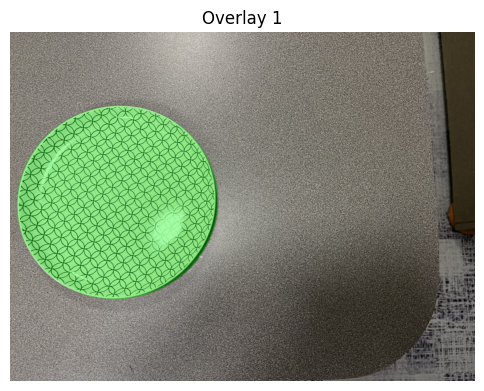

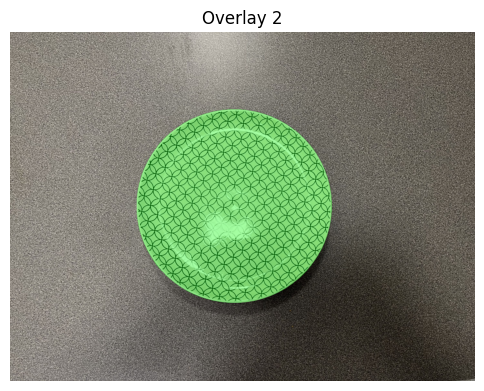

In [11]:
def overlay_mask(img, mask, alpha=0.35):
    color = np.zeros_like(img)
    color[..., 1] = 255  # green overlay
    return np.where(mask[..., None] > 0,
                    (img * (1-alpha) + color * alpha).astype(np.uint8),
                    img)

show_image(overlay_mask(img1, mask1), "Overlay 1")
show_image(overlay_mask(img2, mask2), "Overlay 2")

In [12]:
def extract_plate_geometry(mask: np.ndarray, plate_diameter_cm: float):
    """
    Extract plate geometry from a binary mask.

    Inputs:
        mask: HxW uint8 mask (255 = plate)
        plate_diameter_cm: real-world plate diameter

    Returns dict with:
        center_px
        diameter_px
        cm_per_pixel
        ellipse (cv2 format)
    """

    # --- ensure binary ---
    mask_bin = (mask > 0).astype(np.uint8)

    # --- find contours ---
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if not contours:
        raise ValueError("No contours found in plate mask.")

    # --- take largest contour ---
    cnt = max(contours, key=cv2.contourArea)

    if len(cnt) < 20:
        raise ValueError("Plate contour too small to fit ellipse.")

    # --- fit ellipse ---
    ellipse = cv2.fitEllipse(cnt)
    (cx, cy), (a, b), angle = ellipse

    # major axis is plate diameter in pixels
    diameter_px = max(a, b)

    # --- compute scale ---
    cm_per_pixel = plate_diameter_cm / diameter_px

    return {
        "center_px": (cx, cy),
        "diameter_px": float(diameter_px),
        "cm_per_pixel": float(cm_per_pixel),
        "ellipse": ellipse,
    }

In [13]:
geom1 = extract_plate_geometry(mask1, CONFIG["plate_diameter_cm"])
geom2 = extract_plate_geometry(mask2, CONFIG["plate_diameter_cm"])

print("Image 1:")
print("  diameter_px:", geom1["diameter_px"])
print("  cm_per_pixel:", geom1["cm_per_pixel"])

print("\nImage 2:")
print("  diameter_px:", geom2["diameter_px"])
print("  cm_per_pixel:", geom2["cm_per_pixel"])

Image 1:
  diameter_px: 442.41552734375
  cm_per_pixel: 0.058768280932867

Image 2:
  diameter_px: 429.377197265625
  cm_per_pixel: 0.06055281967830178


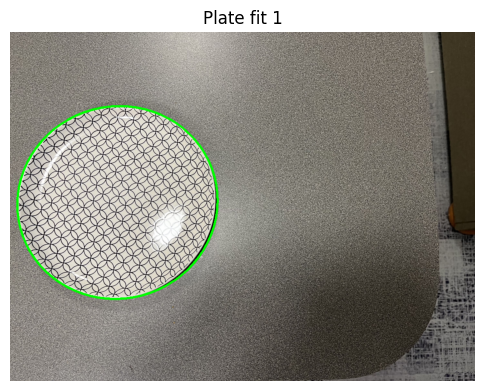

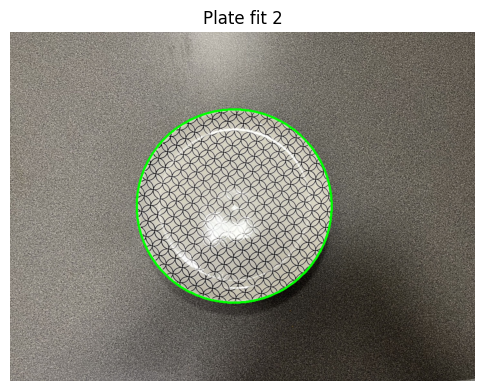

In [14]:
def draw_plate_ellipse_overlay(img, ellipse):
    out = img.copy()
    cv2.ellipse(out, ellipse, (0, 255, 0), 4)
    return out

show_image(draw_plate_ellipse_overlay(img1, geom1["ellipse"]), "Plate fit 1")
show_image(draw_plate_ellipse_overlay(img2, geom2["ellipse"]), "Plate fit 2")

In [15]:
def estimate_relative_pose(img1_rgb, img2_rgb):
    """
    Estimate relative pose between two images.

    Returns dict with:
        R: 3x3 rotation
        t: 3x1 translation (unit norm, up to scale)
        pts1: inlier matched points in img1
        pts2: inlier matched points in img2
        E: essential matrix
    """

    # --- convert to grayscale ---
    gray1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)

    # --- detect ORB features ---
    orb = cv2.ORB_create(
        nfeatures=4000,
        scaleFactor=1.2,
        nlevels=8
    )

    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    if des1 is None or des2 is None:
        raise ValueError("ORB failed to find descriptors.")

    # --- match ---
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    if len(matches) < 20:
        raise ValueError("Not enough matches for pose estimation.")

    # sort by distance
    matches = sorted(matches, key=lambda m: m.distance)

    # take top matches (helps robustness)
    matches = matches[:2000]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # --- camera intrinsics (approx) ---
    # We don't know real intrinsics yet.
    # Use focal ~ image width and center principal point.
    h, w = gray1.shape
    f = w
    K = np.array([
        [f, 0, w/2],
        [0, f, h/2],
        [0, 0, 1]
    ], dtype=np.float64)

    # --- Essential matrix ---
    E, mask = cv2.findEssentialMat(
        pts1,
        pts2,
        K,
        method=cv2.RANSAC,
        prob=0.999,
        threshold=1.0
    )

    if E is None:
        raise ValueError("Essential matrix estimation failed.")

    # keep inliers
    pts1_in = pts1[mask.ravel() == 1]
    pts2_in = pts2[mask.ravel() == 1]

    # --- recover pose ---
    _, R, t, _ = cv2.recoverPose(E, pts1_in, pts2_in, K)

    return {
        "R": R,
        "t": t,
        "pts1": pts1_in,
        "pts2": pts2_in,
        "E": E,
        "K": K,
    }

In [17]:
pose = estimate_relative_pose(img1, img2)

print("Inlier matches:", len(pose["pts1"]))
print("R shape:", pose["R"].shape)
print("t norm:", np.linalg.norm(pose["t"]))

Inlier matches: 59
R shape: (3, 3)
t norm: 1.0


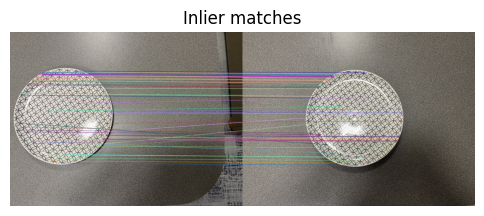

In [18]:
def draw_inlier_matches(img1, img2, pts1, pts2, max_draw=80):
    img1_vis = img1.copy()
    img2_vis = img2.copy()

    n = min(len(pts1), max_draw)
    idx = np.random.choice(len(pts1), n, replace=False)

    kp1 = [cv2.KeyPoint(float(pts1[i][0]), float(pts1[i][1]), 1) for i in idx]
    kp2 = [cv2.KeyPoint(float(pts2[i][0]), float(pts2[i][1]), 1) for i in idx]

    matches = [cv2.DMatch(i, i, 0) for i in range(n)]

    vis = cv2.drawMatches(
        img1_vis, kp1,
        img2_vis, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return vis

vis = draw_inlier_matches(img1, img2, pose["pts1"], pose["pts2"])
show_image(vis, "Inlier matches")

In [23]:
# --- RAFT-Stereo setup (safe to run multiple times) ---
%cd /content
!rm -rf /content/RAFT-Stereo

!git clone https://github.com/princeton-vl/RAFT-Stereo.git
%cd /content/RAFT-Stereo

# Minimal deps
!pip install -q einops imageio scipy tqdm opencv-python-headless

# Download pretrained weights (repo script)
!bash download_models.sh

# Sanity: show models
!ls -lh /content/RAFT-Stereo/models

/content
Cloning into 'RAFT-Stereo'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 87 (delta 40), reused 33 (delta 33), pack-reused 29 (from 1)
Receiving objects: 100% (87/87), 703.11 KiB | 12.55 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/RAFT-Stereo
--2026-02-23 00:31:01--  https://www.dropbox.com/s/ftveifyqcomiwaq/models.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/z720aslw752iypqqdre7c/models.zip?rlkey=3criskutu26wwrx4h9g42aqx0 [following]
--2026-02-23 00:31:01--  https://www.dropbox.com/scl/fi/z720aslw752iypqqdre7c/models.zip?rlkey=3criskutu26wwrx4h9g42aqx0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 3

In [26]:
import sys
import torch
import numpy as np
import cv2
from types import SimpleNamespace

sys.path.append("/content/RAFT-Stereo")

from core.raft_stereo import RAFTStereo
from core.utils.utils import InputPadder

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

WEIGHTS_PATH = "/content/RAFT-Stereo/models/raftstereo-realtime.pth"
assert os.path.exists(WEIGHTS_PATH), f"Missing weights at {WEIGHTS_PATH}. Check /content/RAFT-Stereo/models"

from types import SimpleNamespace

args = SimpleNamespace(
    mixed_precision=True,
    valid_iters=20,

    # required by current RAFT-Stereo repo
    hidden_dims=[128, 128, 128],
    context_norm="batch",
    n_downsample=2,

    corr_implementation="reg",
    corr_levels=4,
    corr_radius=4,

    shared_backbone=True,

    slow_fast_gru=True,
    n_gru_layers=3,
)

model = RAFTStereo(args).to(DEVICE)

ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(ckpt, strict=False)
model.eval()

print("✅ RAFT-Stereo loaded:", WEIGHTS_PATH)

DEVICE: cpu
✅ RAFT-Stereo loaded: /content/RAFT-Stereo/models/raftstereo-realtime.pth


/content/RAFT-Stereo/core/raft_stereo.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/autocast_mode.py:54: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  super().__init__(
/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT-Stereo/core/raft_stereo.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


disp: (768, 1024) min/max: -31.30400276184082 -1.2685704231262207


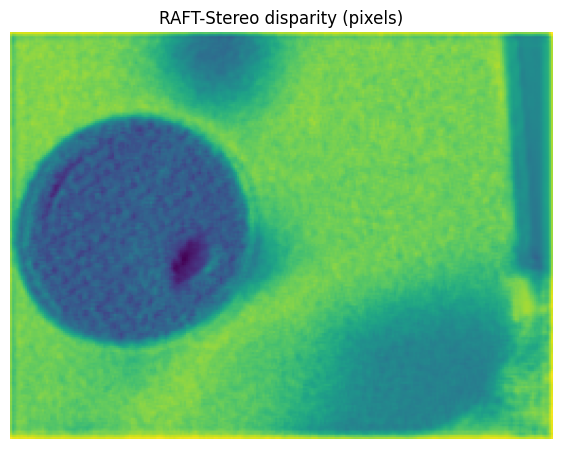

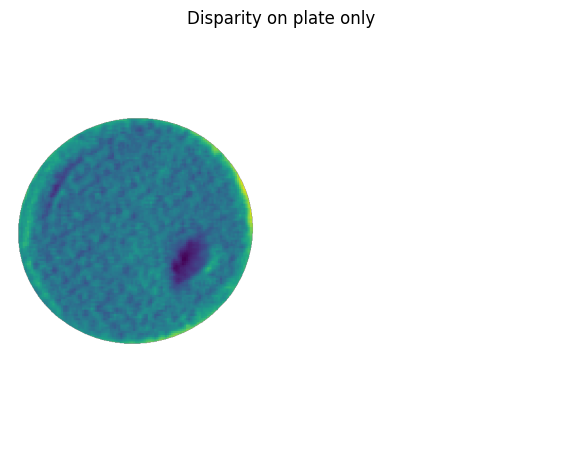

In [27]:
@torch.no_grad()
def raft_stereo_disparity(img1_rgb: np.ndarray, img2_rgb: np.ndarray, iters: int = 20) -> np.ndarray:
    """
    Returns disparity map in pixels (float32), in img1's frame.
    """
    # Ensure same size
    if img1_rgb.shape[:2] != img2_rgb.shape[:2]:
        h = min(img1_rgb.shape[0], img2_rgb.shape[0])
        w = min(img1_rgb.shape[1], img2_rgb.shape[1])
        img1_rgb = cv2.resize(img1_rgb, (w, h), interpolation=cv2.INTER_AREA)
        img2_rgb = cv2.resize(img2_rgb, (w, h), interpolation=cv2.INTER_AREA)

    im1 = torch.from_numpy(img1_rgb).permute(2, 0, 1).float()[None].to(DEVICE)
    im2 = torch.from_numpy(img2_rgb).permute(2, 0, 1).float()[None].to(DEVICE)

    # RAFT expects dims divisible by 8
    padder = InputPadder(im1.shape, divis_by=8)
    im1, im2 = padder.pad(im1, im2)

    flow_low, flow_up = model(im1, im2, iters=iters, test_mode=True)
    flow_up = padder.unpad(flow_up)

    # Horizontal component is disparity (pixels)
    disp = flow_up[0, 0].detach().cpu().numpy().astype(np.float32)
    return disp

disp = raft_stereo_disparity(img1, img2, iters=20)
print("disp:", disp.shape, "min/max:", float(np.min(disp)), float(np.max(disp)))

plt.figure(figsize=(7,7))
plt.title("RAFT-Stereo disparity (pixels)")
plt.imshow(disp)
plt.axis("off")
plt.show()

# Optional: visualize only on the plate if you have mask1
if "mask1" in globals():
    disp_plate = np.where(mask1 > 0, disp, np.nan)
    plt.figure(figsize=(7,7))
    plt.title("Disparity on plate only")
    plt.imshow(disp_plate)
    plt.axis("off")
    plt.show()

In [30]:
import numpy as np

def compute_height_map_from_disparity(
    disp: np.ndarray,
    plate_mask: np.ndarray,
    ransac_iters: int = 300,
    eps: float = 1e-6,
):
    """
    Input:
      disp: HxW float32 disparity (pixels), aligned to img1
      plate_mask: HxW uint8/bool, 255/True=plate

    Output:
      height_map: HxW float32, "height above plate" in RELATIVE units (>=0), 0 outside plate
      plane: (a,b,c) for plane z = a*x + b*y + c fit in z_rel space
      z_rel: HxW float32 = 1/(abs(disp)+eps), 0 where invalid
    """

    H, W = disp.shape[:2]

    # Ensure mask matches disparity shape
    if plate_mask.shape[:2] != (H, W):
        plate_mask = cv2.resize((plate_mask > 0).astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    pm = plate_mask > 0

    disp_abs = np.abs(disp).astype(np.float32)

    # Data-driven validity threshold: ignore near-zero disparity pixels
    d_plate = disp_abs[pm]
    if d_plate.size == 0:
        raise ValueError("Plate mask has no pixels.")

    # pick a conservative threshold: half of the 10th percentile, with a floor
    p10 = float(np.percentile(d_plate, 10))
    disp_min = max(0.01, 0.5 * p10)

    valid = pm & np.isfinite(disp_abs) & (disp_abs > disp_min)

    ys, xs = np.where(valid)
    if len(xs) < 500:
        # fallback: just use a very low threshold
        valid = pm & np.isfinite(disp_abs) & (disp_abs > 0.005)
        ys, xs = np.where(valid)

    if len(xs) < 200:
        raise ValueError(f"Not enough valid plate pixels for plane fit: {len(xs)}")

    # relative depth proxy
    z_rel = np.zeros((H, W), dtype=np.float32)
    z_rel[valid] = 1.0 / (disp_abs[valid] + eps)

    z = z_rel[ys, xs].astype(np.float64)
    X = np.stack([xs.astype(np.float64), ys.astype(np.float64), np.ones_like(xs, dtype=np.float64)], axis=1)

    # Robust RANSAC threshold based on data scale (MAD)
    med = np.median(z)
    mad = np.median(np.abs(z - med)) + 1e-12
    ransac_thresh = float(3.0 * mad)  # adaptive threshold

    best_inliers = None
    best_count = -1
    n = X.shape[0]
    rng = np.random.default_rng(0)

    for _ in range(ransac_iters):
        idx = rng.choice(n, size=3, replace=False)
        A = X[idx]
        b = z[idx]

        if np.linalg.matrix_rank(A) < 3:
            continue

        coeff = np.linalg.solve(A, b)
        resid = np.abs((X @ coeff) - z)

        inliers = resid < ransac_thresh
        count = int(inliers.sum())

        if count > best_count:
            best_count = count
            best_inliers = inliers

    if best_inliers is None or best_count < 200:
        raise ValueError("RANSAC failed to find a stable plane.")

    # Refit plane using least squares on inliers
    Xi = X[best_inliers]
    zi = z[best_inliers]
    coeff, *_ = np.linalg.lstsq(Xi, zi, rcond=None)
    a, b, c = coeff

    yy, xx = np.mgrid[0:H, 0:W]
    plane_z = (a * xx + b * yy + c).astype(np.float32)

    height = np.zeros((H, W), dtype=np.float32)
    height[valid] = plane_z[valid] - z_rel[valid]  # closer than plane => positive
    height = np.maximum(height, 0.0)
    height[~pm] = 0.0

    return height, (float(a), float(b), float(c)), z_rel

plane (a,b,c): (-4.869147166399208e-07, 1.6466049858458346e-06, 0.04444548658546876)
height_map on plate: min/mean/max = 0.0 0.001251542242243886 0.013044081628322601


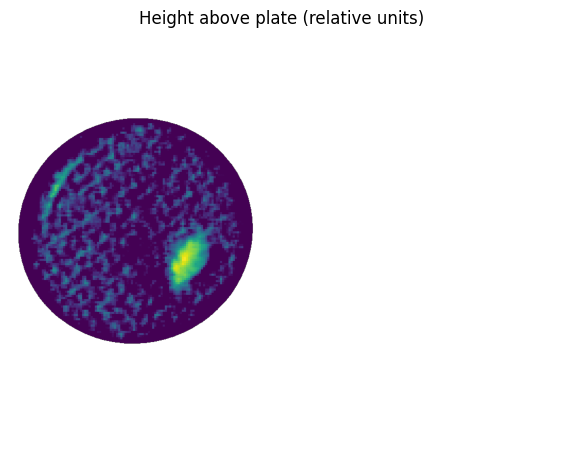

In [31]:
height_map, plane_abc, z_rel = compute_height_map_from_disparity(disp, mask1)

print("plane (a,b,c):", plane_abc)
print("height_map on plate: min/mean/max =",
      float(np.min(height_map[mask1>0])),
      float(np.mean(height_map[mask1>0])),
      float(np.max(height_map[mask1>0])))

plt.figure(figsize=(7,7))
plt.title("Height above plate (relative units)")
plt.imshow(np.where(mask1>0, height_map, np.nan))
plt.axis("off")
plt.show()

In [32]:
def deterministic_height_and_volume(
    height_rel,
    z_rel,
    plate_mask,
    cm_per_pixel,
    plate_diameter_cm,
    eps=1e-6,
):
    pm = plate_mask > 0

    # Characteristic depth of the plate in relative units
    z_plate = float(np.median(z_rel[pm & (z_rel > 0)]))

    if z_plate <= 0:
        raise ValueError("Invalid plate depth scale.")

    # Deterministic conversion:
    # relative height normalized by plate depth scale,
    # then expressed in real-world cm using plate diameter
    height_cm = np.zeros_like(height_rel, dtype=np.float32)
    height_cm[pm] = (height_rel[pm] / (z_plate + eps)) * plate_diameter_cm

    height_cm = np.maximum(height_cm, 0.0)
    height_cm[~pm] = 0.0

    # Volume integration
    pixel_area_cm2 = cm_per_pixel ** 2
    volume_ml = float(np.sum(height_cm[pm]) * pixel_area_cm2)

    return height_cm, volume_ml

Estimated total volume (mL): 369.8797912597656


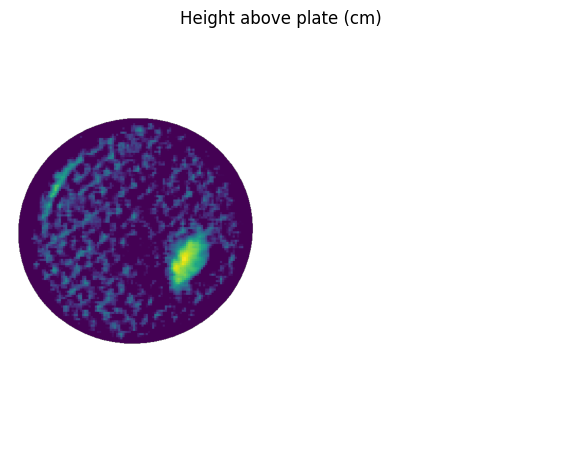

In [33]:
cm_per_pixel = geom1["cm_per_pixel"]
plate_d_cm = CONFIG["plate_diameter_cm"]

height_cm, volume_ml = deterministic_height_and_volume(
    height_map,
    z_rel,
    mask1,
    cm_per_pixel,
    plate_d_cm,
)

print("Estimated total volume (mL):", volume_ml)

plt.figure(figsize=(7,7))
plt.title("Height above plate (cm)")
plt.imshow(np.where(mask1>0, height_cm, np.nan))
plt.axis("off")
plt.show()